In [92]:
# %matplotlib inline
import os
from pprint import pprint
import pickle
from collections import Counter
import statistics as stat
import pandas as pd 
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from scipy.sparse.linalg import eigs
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2grey
import matplotlib.pyplot as plt
import seaborn as sns
import math
import string
from IPython.display import clear_output
from sklearn.tree import DecisionTreeClassifier
import random
from scipy.stats import zscore
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import accuracy_score

random.seed(0)
# plt.rcParams['figure.figsize'] = [8, 8]
sns.set(style = "darkgrid")

%run fns.ipynb
# %run visualize.ipynb

no_of_iter = 10  # for cross validation

In [35]:
path = os.getcwd() + '/dataset/'


data =  collect_letters(path)
data.rename(columns={0: "class"}, inplace = True)
col = list(data.columns)
col = col[1:] + [col[0]]
data = data[col]


# Change A- Z to 0 - 25
alphabets = list(string.ascii_uppercase)
alphabet = {}
for k in range(0, 26):
    alphabet[alphabets[k]] = k
    
for k,v in alphabet.items():
    data.loc[data['class'] == k, 'class' ] = v
    

In [36]:
""" Find no. of data points of each letter"""
letter_count = data['class'].value_counts()
letter_count.sort_index(inplace = True)

In [37]:
""" Randomly split data, to get train and test set """
a = 70

data = data.sample(frac=1).reset_index(drop=True)

nr = int((a/100)*data.shape[0])

train_data = data.iloc[:nr, :]
test_data = data.iloc[nr:, :]

print('Train data: ', train_data.shape, ' Test data: ', test_data.shape)

Train data:  (14000, 17)  Test data:  (6000, 17)


In [38]:
""" Base classifiers """
dt = DecisionTreeClassifier(max_depth = 2, max_leaf_nodes = 3, random_state = 0)
dt.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
base_acc_train = accuracy_score(dt.predict(train_data.iloc[:,:-1]), train_data.iloc[:,-1])
base_acc_test = accuracy_score(dt.predict(test_data.iloc[:,:-1]), test_data.iloc[:,-1])
base_error_test = 100 - base_acc_test*100
print('Error rate on train data using decsion tree classifier:', 100 - base_acc_train*100)
print('Error rate on test data using decsion tree classifier:', 100 - base_acc_test*100)

Error rate on train data using decsion tree classifier: 90.10714285714286
Error rate on test data using decsion tree classifier: 90.8


In [45]:
""" Q2. Part a) and b)""" 
test_error_boosting = []
train_error_boosting = []
rounds = list(range(10,220,30))
# rounds = [1]

for niter in rounds:
    train_Acc, test_Acc = Adaboost(niter, train_data, test_data)
    print('Accuracy of Adaboost on train data for ',niter,' : ', train_Acc, ' %')
    print('Accuracy of Adaboost on test data ',niter,' : ', test_Acc, ' %')
    print('Error of Adaboost on train data for ',niter,' : ', 100 - train_Acc, ' %')
    print('Error of Adaboost on test data for ',niter,' : ', 100 - test_Acc, ' %')
    test_error_boosting.append(100 - test_Acc)
    train_error_boosting.append(100 - train_Acc)


Accuracy of Adaboost on train data for  10  :  14.99  %
Accuracy of Adaboost on test data  10  :  14.2  %
Error of Adaboost on train data for  10  :  85.01  %
Error of Adaboost on test data for  10  :  85.8  %
Accuracy of Adaboost on train data for  40  :  40.09  %
Accuracy of Adaboost on test data  40  :  39.75  %
Error of Adaboost on train data for  40  :  59.91  %
Error of Adaboost on test data for  40  :  60.25  %
Accuracy of Adaboost on train data for  70  :  45.69  %
Accuracy of Adaboost on test data  70  :  45.13  %
Error of Adaboost on train data for  70  :  54.31  %
Error of Adaboost on test data for  70  :  54.87  %
Accuracy of Adaboost on train data for  100  :  49.3  %
Accuracy of Adaboost on test data  100  :  48.73  %
Error of Adaboost on train data for  100  :  50.7  %
Error of Adaboost on test data for  100  :  51.27  %
Accuracy of Adaboost on train data for  130  :  50.42  %
Accuracy of Adaboost on test data  130  :  49.8  %
Error of Adaboost on train data for  130  : 

[90.8]

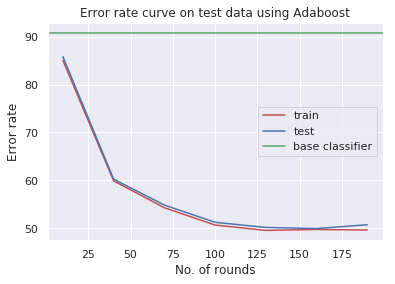

In [52]:
""" Plot no. of rounds vs error """
plt.plot(rounds, train_error_boosting, color = 'r', label='train')
plt.plot(rounds, test_error_boosting, color = 'b', label='test')
plt.xlabel('No. of rounds')
plt.ylabel('Error rate')
plt.title('Error rate curve on test data using Adaboost')
plt.axhline(y=base_error_test,color = 'g', label='base classifier')
plt.legend()

In [103]:
""" Q2. Part c) """

K = 5
crossValidation(train_data.values, K, True) # Adaboost

Cross Validation Fold  0  test set accuracy is : 13.0
Cross Validation Fold  1  test set accuracy is : 17.54
Cross Validation Fold  2  test set accuracy is : 17.82
Cross Validation Fold  3  test set accuracy is : 13.71
Cross Validation Fold  4  test set accuracy is : 15.25
Mean accuracy (boosting):  15.428 % Standard deviation of accuracy:  1.540680369187587
Mean of error rate:  84.572 %  Standard deviation of error rate:  1.5406803691875843


In [94]:
""" Part d) and e) """

minmax_error = []
tanh_error = []
simple_error = []
simple_train_error = []
simple_test_error = []
z_error = []
no_of_rounds = list(range(10,220,30))
# no_of_rounds = [21]

for n in no_of_rounds:
    simple_train, simple_test = bagging(n, train_data, test_data)
    simple_error.append(100 - simple_test)
    simple_test_error.append(100 - simple_test)
    simple_train_error.append(100 - simple_train)
    
    print('Accuracy on test without normalization: ',simple_test)
    
    minmax_train, minmax_test = bagging(n, train_data, test_data, 'minmax')
    minmax_error.append(100 - minmax_test)
    print('Accuracy on test using minmax normalization: ',minmax_test)
    
    tan_train, tan_test = bagging(n, train_data, test_data, 'tanh')
    tanh_error.append(100 - tan_test)
    print('Accuracy on test using tanh normalization: ',tan_test)
    
    z_train, z_test = bagging(n, train_data, test_data, 'zscore')
    z_error.append(100 - z_test)
    print('Accuracy on test using zscore normalization: ',z_test)

Accuracy on test without normalization:  9.2
Accuracy on test using minmax normalization:  7.233333333333333
Accuracy on test using tanh normalization:  12.833333333333332
Accuracy on test using zscore normalization:  12.166666666666668
Accuracy on test without normalization:  9.2
Accuracy on test using minmax normalization:  16.083333333333332
Accuracy on test using tanh normalization:  11.783333333333333
Accuracy on test using zscore normalization:  15.216666666666667
Accuracy on test without normalization:  9.2
Accuracy on test using minmax normalization:  11.116666666666667
Accuracy on test using tanh normalization:  13.083333333333332
Accuracy on test using zscore normalization:  12.166666666666668
Accuracy on test without normalization:  9.2
Accuracy on test using minmax normalization:  14.133333333333335
Accuracy on test using tanh normalization:  9.2
Accuracy on test using zscore normalization:  12.166666666666668
Accuracy on test without normalization:  9.2
Accuracy on test us

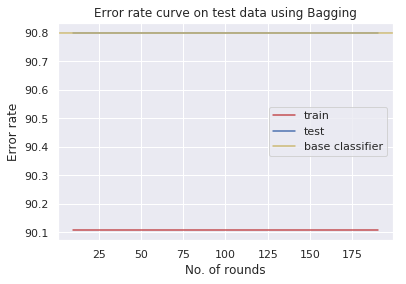

In [101]:
""" Plot no. of rounds vs error without normalisation """
plt.plot(rounds, simple_train_error, color = 'r', label='train')
plt.plot(rounds, simple_test_error, color = 'b', label='test')
plt.xlabel('No. of rounds')
plt.ylabel('Error rate')
plt.title('Error rate curve on test data using Bagging')
plt.axhline(y=base_error_test,color = 'y', label='base classifier')
plt.legend()

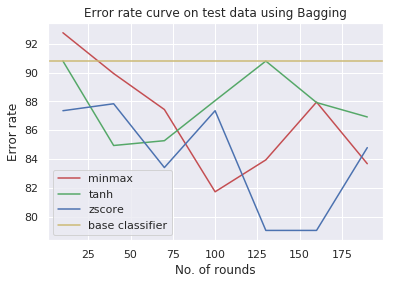

In [54]:
""" Plot no. of rounds vs error """
plt.plot(no_of_rounds, minmax_error, color = 'r', label='minmax')
plt.plot(no_of_rounds, tanh_error, color = 'g', label = 'tanh')
plt.plot(no_of_rounds, z_error, color = 'b', label ='zscore')
plt.plot(no_of_rounds, z_error, color = 'm', label ='without norm.')

plt.xlabel('No. of rounds')
plt.ylabel('Error rate')
plt.title('Error rate curve on test data using Bagging')
plt.axhline(y=base_error_test,color = 'y', label ='base classifier')
plt.legend()

In [102]:
""" Q2. Part d) Bagging """

K = 5
crossValidation(train_data.values, K, False, True)

Cross Validation Fold  0  test set accuracy is : 9.928571428571429
Cross Validation Fold  1  test set accuracy is : 9.25
Cross Validation Fold  2  test set accuracy is : 12.642857142857142
Cross Validation Fold  3  test set accuracy is : 9.928571428571429
Cross Validation Fold  4  test set accuracy is : 9.071428571428571
Mean accuracy(bagging):  10.528571428571428 % Standard deviation of accuracy:  1.1007650400832083
Mean of error rate:  89.47142857142858 %  Standard deviation of error rate:  1.1007650400832063


In [56]:
a = np.array([[1,2,3],[1,4,5],[2,5,3]])

In [65]:
z = np.bincount(a[:,2]).argmax()

int